####**Extracting Dataset from Kaggle**

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khushalivasani","key":"068e58447fd456d8951ff2643f2b5538"}'}

In [3]:
!mkdir -p   ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sizlingdhairya1/leaf-disease

  0% 0.00/3.75M [00:00<?, ?B/s]
100% 3.75M/3.75M [00:00<00:00, 34.8MB/s]


In [5]:
from zipfile import ZipFile
file_name="leaf-disease.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


####**Importing necessary libraries**

In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf 
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import random
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [13]:
datadir = '/content/Datasets'
labels = os.listdir(datadir)
IMG_SIZE = 100

In [14]:
labels

['Bacteria', 'Nematodes', 'Fungi', 'Normal', 'Virus']

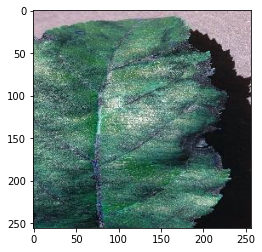

In [15]:
for label in labels:
    path = os.path.join(datadir,label)
    for img in os.listdir(path): 
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break 
    break 

In [16]:
training_data = []

def create_training_data():
    for label in labels:
        path = os.path.join(datadir,label)
        class_num = labels.index(label) 
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

In [17]:
create_training_data()

100%|██████████| 50/50 [00:00<00:00, 774.26it/s]


In [18]:
training_data

[[array([[[201, 178, 192],
          [200, 177, 191],
          [196, 173, 187],
          ...,
          [192, 171, 180],
          [184, 163, 172],
          [200, 179, 188]],
  
         [[194, 171, 185],
          [195, 172, 186],
          [193, 171, 185],
          ...,
          [216, 195, 204],
          [194, 172, 181],
          [218, 197, 206]],
  
         [[191, 168, 182],
          [195, 172, 186],
          [196, 173, 187],
          ...,
          [198, 177, 186],
          [207, 186, 195],
          [205, 184, 193]],
  
         ...,
  
         [[ 54,  74,  79],
          [ 25,  54,  58],
          [  5,  42,  46],
          ...,
          [ 20,  17,  19],
          [ 21,  17,  19],
          [ 21,  18,  20]],
  
         [[ 25,  55,  53],
          [ 17,  54,  52],
          [ 18,  67,  63],
          ...,
          [ 19,  16,  18],
          [ 20,  17,  19],
          [ 21,  18,  20]],
  
         [[ 46,  82,  76],
          [ 22,  68,  60],
          [ 31,  89,  79

In [19]:
print(len(training_data))

239


In [20]:
random.shuffle(training_data)

In [21]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [22]:
X.shape

(239, 100, 100, 3)

In [23]:
y = np.array(y)
y.shape

(239,)

In [24]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [29]:
model = Sequential()
model.add(Dropout(0.25))
model.add(Conv2D(32,(5, 5),activation='relu',kernel_initializer="he_uniform",padding="same",input_shape = X.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(5, 5), activation="relu",kernel_initializer="he_uniform",padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(5, 5), activation='relu',kernel_initializer="he_uniform",padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))


In [30]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)
X_train = X_train/255
X_test = X_test/255

In [33]:
from keras import utils as np_utils
y_train=keras.utils.np_utils.to_categorical(y_train,10)
y_test=keras.utils.np_utils.to_categorical(y_test,10)

In [34]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
history = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),
                               validation_data=(X_test, y_test),epochs=50, verbose=1)

Epoch 1/50
6/6 [==============================] - 8s 1s/step - loss: 5.2475 - accuracy: 0.1728 - val_loss: 2.2578 - val_accuracy: 0.2083
Epoch 2/50
6/6 [==============================] - 7s 1s/step - loss: 2.1647 - accuracy: 0.1518 - val_loss: 2.2149 - val_accuracy: 0.2500
Epoch 3/50
6/6 [==============================] - 7s 1s/step - loss: 2.0700 - accuracy: 0.2042 - val_loss: 2.1820 - val_accuracy: 0.1875
Epoch 4/50
6/6 [==============================] - 7s 1s/step - loss: 1.9934 - accuracy: 0.2461 - val_loss: 2.1996 - val_accuracy: 0.1458
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 2.0018 - accuracy: 0.2042 - val_loss: 2.1762 - val_accuracy: 0.2083
Epoch 6/50
6/6 [==============================] - 7s 1s/step - loss: 1.9394 - accuracy: 0.2042 - val_loss: 2.1336 - val_accuracy: 0.1458
Epoch 7/50
6/6 [==============================] - 7s 1s/step - loss: 1.8863 - accuracy: 0.2199 - val_loss: 2.1547 - val_accuracy: 0.1458
Epoch 8/50
6/6 [=========================

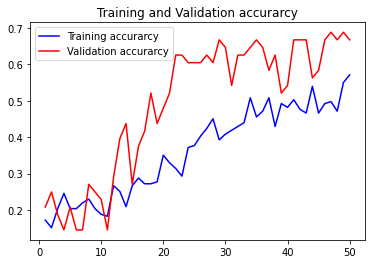

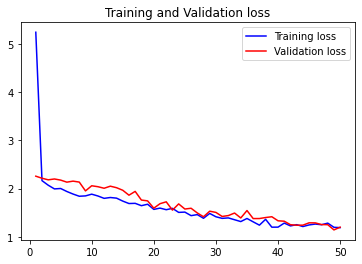

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [37]:
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

2/2 [==============================] - 0s 126ms/step - loss: 1.1981 - accuracy: 0.6667
Test Accuracy: 66.66666865348816


In [38]:
model.save('leaf_disease.h5')